In [1]:
import pandas as pd
import geopandas as gpd
import h3
import h3pandas
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import numpy as np
from shapely.geometry import Polygon, Point
from typing import cast
import os

In [4]:
### Define directories and dataset names
#ROOT_DIR = os.path.abspath(os.curdir)
#in_path = ROOT_DIR
#out_path = ROOT_DIR + "/Outputs"
region_col_name = "NAME_2"

# 1 Shape files

In [6]:
# Coordinate and projection systems
#crs_WGS84 =CRS("EPSG:4326")    # Originan WGS84 coordinate system
#crs_proj = CRS("EPSG:24817")    # Projection system for the selected country -- see http://epsg.io/ for more info

In [7]:
admin2_gdf = gpd.read_file("../shapefiles/gadm41_ECU_shp/gadm41_ECU_2.shp")
admin_gdf = gpd.read_file("../shapefiles/gadm41_ECU_shp/gadm41_ECU_1.shp")
region_gdf = gpd.read_file("../shapefiles/gadm41_ECU_shp/gadm41_ECU_0.shp")
print(admin_gdf.crs)

EPSG:4326


# 2 Load parroquia shapefile and voting data

In [10]:
# Load voting data
votos = pd.read_csv("../cne_web_scrp/resultados_referendum_20251119_190005.csv")

print(f"Loaded {len(votos)} voting records")
print(votos.head(5))

Loaded 10336 voting records
   provincia_id provincia  canton_id                 canton  parroquia_id  \
0             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   
1             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   
2             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   
3             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   
4             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   

               parroquia  intCodDignidad  strOrdPartido  intCodPartido  \
0  CAMILO PONCE ENRIQUEZ              25              1           9925   
1  CAMILO PONCE ENRIQUEZ              25              2           9925   
2  CAMILO PONCE ENRIQUEZ              26              1           9926   
3  CAMILO PONCE ENRIQUEZ              26              2           9926   
4  CAMILO PONCE ENRIQUEZ              27              1           9927   

              strNomPartido strLisPartido strNomCandidato  intVo

# 3 Normalize name columns to uppercase for robust join

In [11]:
sub_id = 'canton_id'
sub = 'canton'
row_col = 'NAME_2'
row_col_clean = 'NAME_2_clean'

# 1) Normalize name columns to uppercase for robust join
votos[sub] = votos[sub].str.upper()

# If you join by canton:
admin2_gdf[row_col] = admin2_gdf[row_col].str.upper()  # or adjust to the correct name column

Check what is in votos and not voting data

In [12]:
print(set(votos[sub].str.upper()) - set(admin2_gdf[row_col].str.upper()))

{'LIMON INDANZA', 'SUECIA', 'CRNL MARCELINO MARIDUENAS', 'PUERTO LOPEZ', 'COLOMBIA', 'ALAUSI', 'VENEZUELA', 'BIBLIAN', 'SUCUA', 'ISRAEL', 'ESPAÑA', 'PAJAN', 'NABON', 'FCO.DE ORELLANA', 'EL SALVADOR', 'GIRON', 'C. J. AROSEMENA TOLA', 'BELGICA', 'SEVILLA DON BOSCO', 'DELEG', 'URCUQUI', 'PUCARA', 'GUATEMALA', 'SUIZA', 'PAISES BAJOS (HOLANDA)', 'JUNIN', 'YANZATZA', 'A.BAQUERIZO MORENO', 'JAPON', 'ECHEANDIA', 'BAÑOS', 'JOYA DE LOS SACHAS', 'PARAGUAY', 'EGIPTO', 'HUNGRIA', 'ARGENTINA', 'QUININDE', 'BOLIVIA', 'ALEMANIA', 'BOLIVAR', 'PANAMA', 'CANADA', 'SAN CRISTOBAL', 'CHINA', 'REPUBLICA DOMINICANA', 'MACARA', 'REINO UNIDO DE GRAN BRETAÑA E IRLANDA DEL NORTE', 'TULCAN', 'MARCABELI', 'ESPINDOLA', 'YAGUACHI', 'LA MANA', 'ITALIA', 'CHILE', 'CUBA', 'HONDURAS', 'SAMBORONDON', 'URUGUAY', 'COSTA RICA', 'SUDAFRICA', 'PUJILI', 'JARAMIJO', 'NOBOL / PIEDRAHITA', 'BUENA FE', 'RIO VERDE', 'SUCUMBIOS', 'PERU', 'INDONESIA', 'GRAL. A. ELIZALDE', 'CENTINELA DEL CONDOR', 'PELILEO', 'ESTADOS UNIDOS DE AMERICA',

Check what is in admin gdf and not voting data

In [13]:
print(set(admin2_gdf[row_col].str.upper()) - set(votos[sub].str.upper()) )

{'SAN MIGUEL DE URCUQUÍ', 'SAQUISILÍ', 'YANTZAZA', 'JUNÍN', 'ORELLANA', 'LA MANÁ', 'GONZANAMÁ', 'GIRÓN', 'LIMÓN INDANZA', 'SUCUMBÍOS', 'DURÁN', 'RÍO VERDE', 'ESPÍNDOLA', 'QUININDÉ', 'CARLOS JULIO AROSEMENA TOLA', 'BUENA FÉ', 'MARCABELÍ', 'NOBOL', 'SAN PEDRO DE PELILEO', 'SAN JACINTO DE YAGUACHI', 'GENERAL ANTONIO ELIZALDE', 'LA JOYA DE LOS SACHAS', 'SANTIAGO DE PILLARO', 'JARAMIJÓ', 'URBINA JADO', 'ALFREDO BAQUERIZO MORENO', 'ECHEANDÍA', 'NABÓN', 'BIBLIÁN', 'PUERTO LÓPEZ', 'SAN CRISTÓBAL', 'MONTÚFAR', 'PUJILÍ', 'TULCÁN', 'PUCARÁ', 'BAÑOS DE AGUA SANTA', 'SAMBORONDÓN', 'MEJÍA', 'CENTINELA DEL CÓNDOR', 'SUCÚA', 'CORONEL MARCELINO MARIDUEÑA', 'MACARÁ', 'ALAUSÍ', 'DÉLEG', 'SAN MIGUEL DE LOS BANCOS', 'BOLÍVAR', 'PAJÁN'}


Change accented characters in voting data to match shapefile

In [14]:
from unidecode import unidecode

# Example: clean both columns in-place
admin2_gdf[row_col_clean] = admin2_gdf[row_col].astype(str).apply(lambda x: unidecode(x).upper())
#vote_df['canton_CLEAN']   = vote_df['canton'].astype(str).apply(lambda x: unidecode(x).upper())

In [15]:
# check differences again
print(set(admin2_gdf[row_col_clean].str.upper()) - set(votos[sub].str.upper()) )

{'YANTZAZA', 'ORELLANA', 'CORONEL MARCELINO MARIDUENA', 'BANOS DE AGUA SANTA', 'CARLOS JULIO AROSEMENA TOLA', 'PINAS', 'NOBOL', 'SAN PEDRO DE PELILEO', 'CANAR', 'LOGRONO', 'SAN JACINTO DE YAGUACHI', 'GENERAL ANTONIO ELIZALDE', 'LA JOYA DE LOS SACHAS', 'SAN MIGUEL DE URCUQUI', 'SANTIAGO DE PILLARO', 'URBINA JADO', 'ALFREDO BAQUERIZO MORENO', 'ONA', 'SAN MIGUEL DE LOS BANCOS', 'RUMINAHUI'}


## 3.1 Process voting data

In [16]:
# Aggregate votes by parroquia and question
votos_parr = votos.groupby([sub_id, sub, 'intCodDignidad']).apply(
    lambda x: pd.Series({
        'total_votes': x['intVotos'].sum(),
        'yes_votes': x[x['strNomCandidato'] == 'SI']['intVotos'].sum(),
        'no_votes': x[x['strNomCandidato'] == 'NO']['intVotos'].sum()
    })
).reset_index()

votos_parr['yes_pct'] = (votos_parr['yes_votes'] / votos_parr['total_votes']) * 100

# Map question codes to names
question_map = {
    25: 'Q1',
    26: 'Q2',
    27: 'Q3',  # adjust based on your data
    28: 'Q4'
}

votos_parr['question'] = votos_parr['intCodDignidad'].map(question_map)

# Pivot to wide format
votos_wide = votos_parr.pivot_table(
    index=[sub_id, sub],
    columns='question',
    values=['yes_pct', 'total_votes']
).reset_index()

# Flatten column names
votos_wide.columns = ['_'.join(col).strip('_') for col in votos_wide.columns.values]

print(votos_wide.head())

   canton_id    canton  total_votes_Q1  total_votes_Q2  total_votes_Q3  \
0          5    TULCAN         62044.0         61858.0         61910.0   
1         10  MONTUFAR         21554.0         21487.0         21501.0   
2         11  ALEMANIA          1161.0          1161.0          1160.0   
3         15    ESPEJO         10909.0         10891.0         10891.0   
4         20      MIRA          9865.0          9845.0          9844.0   

   total_votes_Q4  yes_pct_Q1  yes_pct_Q2  yes_pct_Q3  yes_pct_Q4  
0         60348.0   41.562440   46.021533   52.182200   39.732883  
1         21087.0   32.499768   36.356867   42.216641   31.175606  
2          1153.0   47.803618   48.664944   54.137931   47.181266  
3         10648.0   29.214410   32.439629   37.563126   28.399699  
4          9613.0   23.071465   25.068563   29.571312   21.762197  


C:\Users\rheredia\AppData\Local\Temp\ipykernel_27112\455773401.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  votos_parr = votos.groupby([sub_id, sub, 'intCodDignidad']).apply(


## 3.2 Merge votes into the GeoDataFrame

In [17]:

# Example: join by canton name
admin_votes = admin2_gdf.merge(
    votos_wide,
    left_on=row_col_clean,    # change to your real canton field, e.g., 'NAME_2', 'row_col'
    right_on=sub,   # change to your real canton field in votos, e.g., 'canton' 'sub'
    how='left'
)
# Check the result
print(admin_votes.columns)
print(admin_votes[[sub, 'yes_pct_Q1', 'yes_pct_Q2']].head())

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry', 'NAME_2_clean', 'canton_id', 'canton', 'total_votes_Q1',
       'total_votes_Q2', 'total_votes_Q3', 'total_votes_Q4', 'yes_pct_Q1',
       'yes_pct_Q2', 'yes_pct_Q3', 'yes_pct_Q4'],
      dtype='object')
                  canton  yes_pct_Q1  yes_pct_Q2
0  CAMILO PONCE ENRIQUEZ   29.607527   30.966289
1              CHORDELEG   36.519014   39.273975
2                 CUENCA   41.077624   45.364699
3                 EL PAN   29.085140   32.309322
4                  GIRON   44.015030   46.762881


# 4 Plot a single map (one question)
Example: Yes % for Question 1

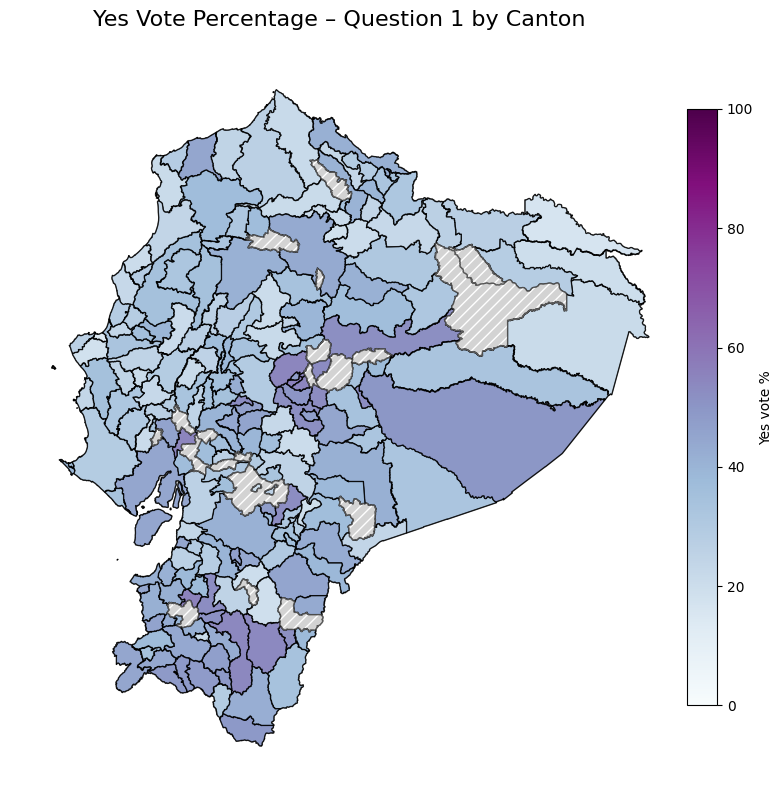

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))

admin_votes.plot(
    column='yes_pct_Q1',
    ax=ax,
    legend=True,
    cmap='BuPu',   # green = higher %, red = lower %
    edgecolor='black',
    linewidth=0.5,
    vmin=0,
    vmax=100,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    },
    legend_kwds={
            'label': 'Yes vote %',
            'orientation': 'vertical',
            'shrink': 0.8,
            'pad': 0.02
        }
    
)

admin2_gdf.plot(ax=ax, edgecolor='black', color='None', alpha=0.4)
region_gdf.plot(ax=ax, edgecolor='black', color='None', alpha=0.4)

ax.set_xlim(-81.5, -75)
ax.set_title('Yes Vote Percentage – Question 1 by Canton', fontsize=16)
#ax.set_xlabel('Longitude (°)')
#ax.set_ylabel('Latitude (°)')
ax.set_axis_off()
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig("../outputs/fig/ecu_referendum_q1_canton.png", dpi=300)
plt.show()

# 5 Plot multiple maps (all questions)

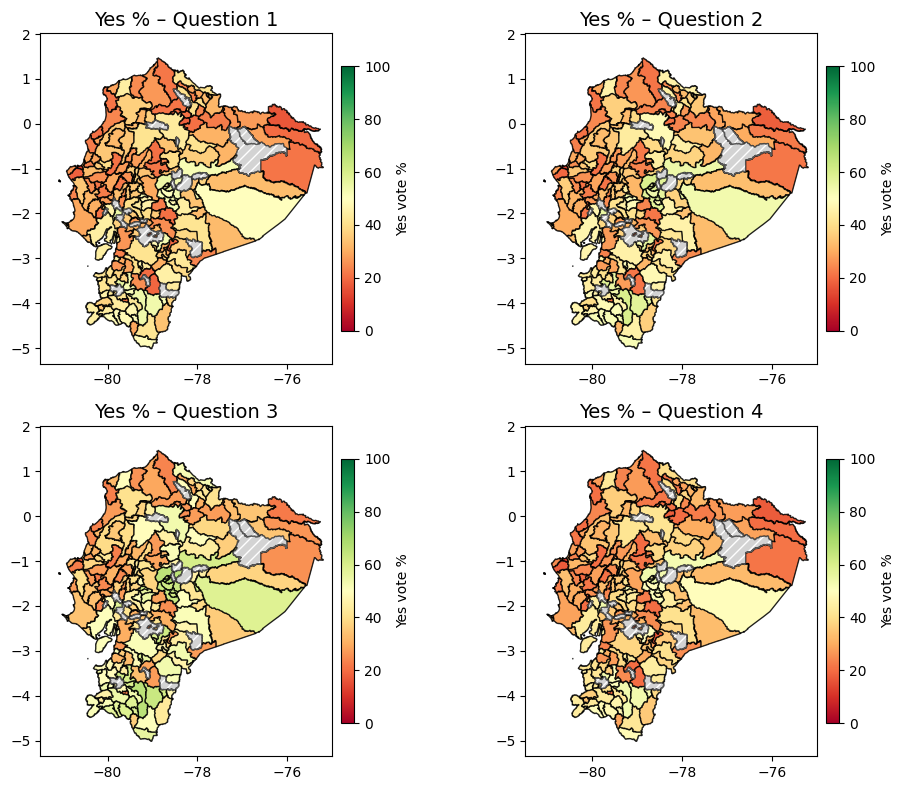

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

questions = ['yes_pct_Q1', 'yes_pct_Q2', 'yes_pct_Q3', 'yes_pct_Q4']
titles = [
    'Yes % – Question 1',
    'Yes % – Question 2',
    'Yes % – Question 3',
    'Yes % – Question 4'
]

for ax, col, title in zip(axes, questions, titles):
    admin_votes.plot(
        column=col,
        ax=ax,
        legend=True,
        cmap='RdYlGn',
        edgecolor='black',
        linewidth=0.4,
        vmin=0,
        vmax=100,
        missing_kwds={
            "color": "lightgrey",
            "edgecolor": "white",
            "hatch": "///",
            "label": "No data"
        },
        legend_kwds={
            'label': 'Yes vote %',
            'orientation': 'vertical',
            'shrink': 0.8,
            'pad': 0.02
        }
    )
    admin2_gdf.plot(ax=ax, edgecolor='black', color='None', alpha=0.4)
    region_gdf.plot(ax=ax, edgecolor='black', color='None', alpha=0.4)

    ax.set_xlim(-81.5, -75)
    ax.set_title(title, fontsize=14)
    #ax.set_xlabel('Longitude (°)')
    #ax.set_ylabel('Latitude (°)')
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig("../outputs/fig/ecu_referendum_all_questions_canton.png", dpi=300)
plt.show()